In [1]:
import pyross.tsi as pyrosstsi 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .1,   0])   # Mean infectiousness 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection?
Nk = 10

#define a time-dependent contact matrix.
#variations on timescale less than T/Nk may not be resolved.
def contactMatrix(t):
    return np.array([[4, 1],[1, 2]]);
    
#######################################
###                                 ###
###    Infecteds Characteristics    ###
###         -Biological-            ###
###                                 ###
#######################################

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pD = 1-pR;             #probability of death for each age class

#prepare for a linear interpolating function evaluated at times:
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])   

phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)

##########################
##Processing User inputs##
##########################

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))

#normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
phiR,  phiD  = phiR/np.trapz(phiR,tsi_sc),  phiD/np.trapz(phiD,tsi_sc)

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiD]), np.array([pR, pH, pD])

#######################################
###                                 ###
###    Infecteds Characteristics    ###
###            -Social-             ###
###                                 ###
#######################################

Qclasses = ['Voluntary', 'Assigned']
TQ = 1.1*T   #how long does an 'assigned' quarantine last? [Must be longer than or equal to T if phiQA_out not modelled]

nQ = len(Qclasses) #Not currently set up to handle anything besides nQ = 2...

#describe how people move in and out of quarantine:
def pQV(t):  return 0.3*np.ones(M)    #time-dependent proportion of each age group that voluntarily quarantines
def pQA(t):  return 0.2*np.ones(M)    #time-dependent proportion of each age group assigned to quarantine.

#probability density function for the time since infection at which people move in/out of quarantine:
tsiQ     =  np.array([0,  2,  4,  6,  8,  10, 12,  T]) #We assume that all voluntary quarantines of infected people
                                                       #end by the time that person is no longer infectious
#Voluntary quarantines:
phiQV_in =  np.array([0, .5, .8, .2, .1,  .0,  0,  0]) #probability density for moving into vol. Quarantine
phiQV_out = np.array([0,  0,  0,  0, .1,  .3, .5, .5]) #probability density for moving out of vol Quarantine
                                                       #(arbitrary units)

#Assigned Quarantines:
phiQA_in =  np.array([0, .5, .8, .2, .1,  .0,  0,  0]) #probability density for moving into assigned Quarantine
                                                       #(arbitrary units)
#phiQA_out is just equal, opposite, and time-shifted to times > T.  Not worth tracking, better to back-calc exits.

#initial conditions for assigned quarantines:
Phi_QA_0 = np.zeros((Nk,M))
#[note this method only accounts for quarantines assigned AFTER starting point]

#define a separate contact matrix for quarantined:
def contactMatrixQ(t):
    return 0*np.array([[1,0],[0,.5]])

##########################
##Processing User inputs##
##########################
phiQV = np.add(-phiQV_out/np.trapz(phiQV_out,tsiQ),phiQV_in/np.trapz(phiQV_in,tsiQ))
#transform this to a cumulative distribution function for the number presently in quarantine
PhiQV = np.zeros(len(tsiQ))
for i in range(len(tsiQ)-1):
    PhiQV[i+1] = PhiQV[i] + 1/2*(tsiQ[i+1] -tsiQ[i])*(phiQV[i+1] + phiQV[i])

phiQA = phiQA_in/np.trapz(phiQA_in,tsiQ)


In [3]:
              
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix,
              'tsiQ':tsiQ, 'TQ':TQ, 'PhiQV':PhiQV, 'phiQA':phiQA, 'Phi_QA_0':Phi_QA_0, 'pQV_t':pQV,
              'pQA_t':pQA, 'CijQ_t':contactMatrixQ}

model = pyrosstsi.deterministic.Simulator(parameters)
IC    = model.get_IC()
data  = model.simulate(IC)

## Plot the results

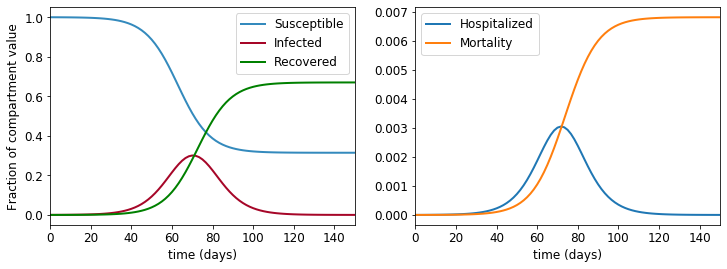

In [4]:
#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);   